RGB Values:
[[121  83   3]
 [125  87   7]
 [125  85   2]
 [123  82   0]
 [124  86   2]
 [117  79   0]
 [121  84   2]
 [123  85   1]
 [125  88   0]
 [126  89   1]
 [129  90   1]
 [119  83   0]
 [122  83   1]
 [130  88   3]
 [128  89   4]
 [129  91   2]
 [129  92   5]
 [132  92   0]
 [128  89   1]
 [130  93   1]
 [129  90   1]
 [131  89   1]
 [129  92   0]
 [130  87   5]
 [129  91   1]
 [136  98   0]
 [132  93   0]
 [141  99   1]
 [ 38   4   3]
 [134  95   2]
 [131  94   0]
 [ 40   4   4]
 [134  91   1]
 [130  95   3]
 [135  96   2]
 [131  93   3]
 [133  92   0]
 [140  96   4]
 [140  96   1]
 [137  98   3]
 [141  98   2]
 [137  99   2]
 [135  93   1]
 [140  97   4]
 [133  93   0]
 [133  96   1]
 [142  98   6]
 [127  88   3]
 [136  95   2]
 [149 106  12]
 [142  98   0]
 [145 103   3]
 [141  98   3]
 [139  99   1]
 [137  93   3]
 [135  95   0]
 [139  96   3]
 [155 115  31]
 [136  97   0]
 [136  93   4]
 [143 100   0]
 [143 103   0]
 [143  97   4]
 [ 41   7   8]
 [143  98   0]
 [142 100   4

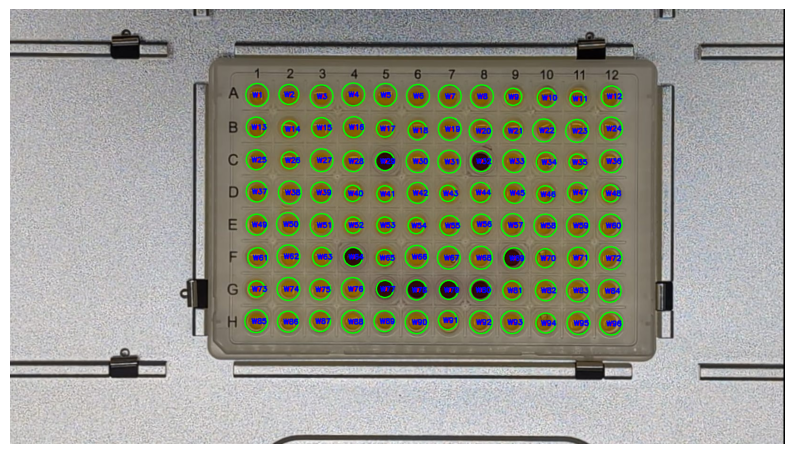

In [8]:

import cv2 as cv  
import numpy as np  
import matplotlib.pyplot as plt  

class Image_processing:
    def __init__(self, image_path, expected_grid=(8, 12)):
        """
        Initialises the Image_processing class with the image path and expected grid dimensions.
        
        Args:
            image_path (str): Path to the image file.
            expected_grid (tuple): Expected grid dimensions (rows, columns) for the well plate.
        """
        self.image_path = image_path  # Store the image path
        self.expected_grid = expected_grid  # Store the expected grid dimensions
        self.image = cv.imread(image_path)  # Load the image using OpenCV
        self.best_circles = None  # Placeholder for detected circles

    def filter_circular_contours(self, contours):
        """
        Filters contours to keep only those that are  circular.
        
        Args:
            contours (list): List of contours detected in the image.
        
        Returns:
            list: List of radii of contours that are  circular.
        """
        # List to store radii of valid circular contours
        valid_circle = []  
        for cont in contours:
            # Calculate the perimeter of the contour
            perimeter = cv.arcLength(cont, True)  

            # Calculate the area of the contour
            area = cv.contourArea(cont)  
            # Avoid division by zero
            if perimeter == 0:
                continue  
            circularity = 4 * np.pi * (area / (perimeter ** 2))  
            if 0.8 < circularity < 1.2:  
                _, radius = cv.minEnclosingCircle(cont)  
                valid_circle.append(radius)  
        return valid_circle
    
    def enforce_grid_pattern(self, circles):
        """
        Enforces a grid pattern on the detected circles to align them with the expected well plate layout.
        
        Args:
            circles (np.ndarray): Detected circles.
        
        Returns:
            np.ndarray: Array of circles aligned in a grid pattern.
        """
        if circles is None or len(circles[0]) < 2:
            return None  
        
        # Extract (x, y, radius) positions of the circles
        circle_positions = circles[0, :, :3]  # Include radius
        
        # Sort circles by Y-coordinate (row-wise sorting)
        sorted_by_y = sorted(circle_positions, key=lambda p: p[1])
        
        # Group circles into rows based on proximity in Y-coordinate
        rows = []
        row_threshold = np.mean(np.diff(sorted_by_y, axis=0)[:, 1]) / 2  # estimate row spacing
        current_row = [sorted_by_y[0]]

        for i in range(1, len(sorted_by_y)):
            if abs(sorted_by_y[i][1] - current_row[-1][1]) < row_threshold:
                current_row.append(sorted_by_y[i])  # Add to current row if Y-coordinate is close
            else:
                rows.append(sorted(current_row, key=lambda p: p[0]))  # Sort row by X-coordinate
                current_row = [sorted_by_y[i]]  # Start a new row

        rows.append(sorted(current_row, key=lambda p: p[0]))  # Add the last row

        # Flatten rows back into a single array
        sorted_circles = np.array([circle for row in rows for circle in row])

        # Limit to expected number of wells (8x12 = 96)
        if len(sorted_circles) > self.expected_grid[0] * self.expected_grid[1]:
            sorted_circles = sorted_circles[:self.expected_grid[0] * self.expected_grid[1]]

        return np.array([sorted_circles], dtype=np.uint16)

    def extract_rgb_values(self, circles, radius=1):
        """
        Extracts the average RGB values at the centers of detected circles.
        
        Args:
            circles (np.ndarray): Detected circles.
            radius (int): Radius for averaging RGB values.
        
        Returns:
            np.ndarray: Array of mean RGB values for each circle.
        """
        # Convert the image from OpenCV's default BGR format to RGB 
        image_rgb = cv.cvtColor(self.image, cv.COLOR_BGR2RGB)
        
        # List to store the mean RGB values for each detected circle
        rgb_values = []
        
        # Iterate through all detected circles to extract RGB values
        for circle in circles[0, :]:
            x, y = circle[0], circle[1]
            rgb = np.zeros(3, dtype=np.float32)
            count = 0
            
            # Iterate over the surrounding pixels within the specified radius to compute mean RGB
            for i in range(-radius, radius + 1):
                for j in range(-radius, radius + 1):
                    # Ensure pixel coordinates are within valid bounds of the image
                    if 0 <= y + i < image_rgb.shape[0] and 0 <= x + j < image_rgb.shape[1]:
                        rgb += image_rgb[y + i, x + j]
                        count += 1
            
            # Compute mean RGB value
            rgb /= count  
            rgb_values.append(rgb.astype(int))
        
        return np.array(rgb_values)

    def auto_hough_circle_detection(self):
        """
        Detects circles in an image and extracts RGB values.
        
        Returns:
            np.ndarray: Array of RGB values for each detected circle, or None if detection fails.
        """
        # Convert the image to grayscale
        gray = cv.cvtColor(self.image, cv.COLOR_BGR2GRAY)
        
        # Apply Contrast Limited Adaptive Histogram Equalization (CLAHE) to enhance contrast
        clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        gray = clahe.apply(gray)
        
        # Apply median blur to reduce noise
        blurred = cv.medianBlur(gray, 5)
        
        # Detect edges using the Canny edge detector
        edges = cv.Canny(blurred, 50, 150)

        # Find contours in the edge-detected image
        contours, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

        if not contours:
            print("No contours found. Check image quality.")
            return None

        # Filter circular contours only
        valid_circle = self.filter_circular_contours(contours)

        if len(valid_circle) < 5:
            print("Not enough valid circles detected from contours.")
            return None

        # Controls threshold for detecting circles and is adjusted to optimise detection.
        param2 = 50
        best_circles = None
        
        # Loop progressively lowers param2 to increase sensitivity
        while param2 >= 10:
            # Circle detection using Hough Circles
            circles = cv.HoughCircles(
                blurred, 
                cv.HOUGH_GRADIENT, 
                dp=1.2, 
                minDist=15,  
                param1=50, 
                param2=param2,  
                minRadius=15, 
                maxRadius=25
            )

            # Compare circles with well plate
            if circles is not None and circles.shape[1] >= self.expected_grid[0] * self.expected_grid[1]:
                best_circles = circles
                break  
            param2 -= 5  
        
        # If circles are detected, enforce grid pattern to remove outliers
        if best_circles is not None:
            best_circles = self.enforce_grid_pattern(best_circles)
            if best_circles is not None:
                rgb_values = self.extract_rgb_values(best_circles)
                self.best_circles = best_circles
                
                # Return the array of RGB values
                return rgb_values
    
        print("Circle detection failed.")
        return None

    def plot_picture(self):
        """
        Plots the image with detected circles and labels.
        
        Returns:
            None: Displays the image using matplotlib.
        """
        if self.best_circles is not None:
            image = self.image.copy()
            for idx, circle in enumerate(self.best_circles[0, :]):
                center = (circle[0], circle[1])
                radius = circle[2]
                cv.circle(image, center, radius, (0, 255, 0), 2)  # Draw green circle
                cv.circle(image, center, 5, (0, 0, 255), -1)  # Draw red bullseye
                cv.putText(image, f"W{idx + 1}", (center[0] - 10, center[1] + 5), 
                            cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)  # Label the circle
            
            # Display result
            plt.figure(figsize=(10, 10))
            plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()

# Example
processor = Image_processing('demo.jpg', expected_grid=(8, 12))
rgb_values = processor.auto_hough_circle_detection()
if rgb_values is not None:
    print("RGB Values:")
    print(rgb_values)
processor.plot_picture()

RGB Values:
[[119 111  88]
 [118 113  85]
 [114 104  59]
 [116 107  65]
 [133 124 101]
 [126 114  80]
 [119 111  73]
 [134 126  95]
 [115 107  78]
 [120 115  85]
 [125 119  84]
 [128 120  92]
 [131 123  92]
 [137 129  98]
 [138 127 100]
 [119 111  70]
 [117 115 103]
 [122 115  80]
 [123 118  80]
 [125 117  75]
 [132 132 107]
 [124 115  69]
 [135 126  89]
 [139 128  99]
 [106 102  56]
 [115 110  71]
 [122 112  69]
 [120 111  66]
 [121 111  59]
 [102  63  64]
 [124 118  77]
 [116 102  45]
 [111 100  52]
 [115 109  67]
 [114  86  85]
 [123 115  70]
 [118 111  62]
 [116 107  61]
 [101  67  66]
 [119 109  60]
 [112 102  73]
 [110 101  40]
 [115 103  42]
 [119 109  56]
 [118 110  50]
 [117 108  53]
 [ 98  57  57]
 [118 107  59]
 [110 101  65]
 [108  99  52]
 [116 107  52]
 [114 107  52]
 [117 108  41]
 [123 113  50]
 [ 96  52  54]
 [119 103  43]
 [105  95  36]
 [111  98  42]
 [ 91  44  49]
 [116 102  36]
 [123 111  35]
 [129 115  40]
 [ 84  40  43]
 [119 106  34]
 [102  94  37]
 [109  98  37

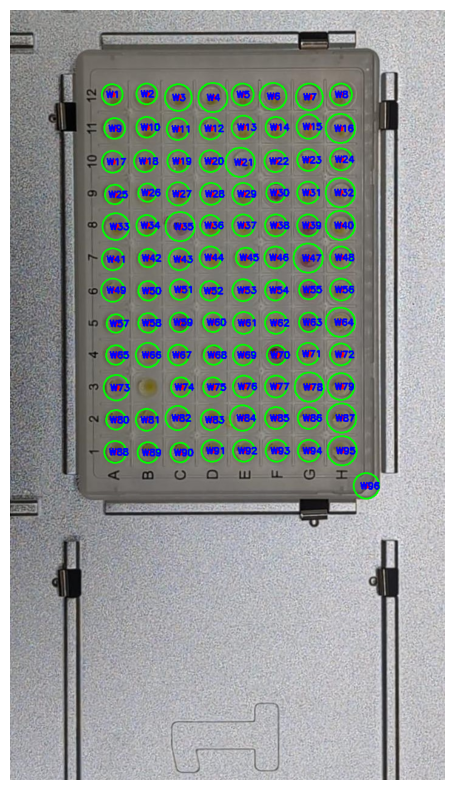

In [1]:

import cv2 as cv  
import numpy as np  
import matplotlib.pyplot as plt  

class Image_processing:
    def __init__(self, image_path, expected_grid=(8, 12)):
        """
        Initialises the Image_processing class with the image path and expected grid dimensions.
        
        Args:
            image_path (str): Path to the image file.
            expected_grid (tuple): Expected grid dimensions (rows, columns) for the well plate.
        """
        self.image_path = image_path  # Store the image path
        self.expected_grid = expected_grid  # Store the expected grid dimensions
        self.image = cv.imread(image_path)  # Load the image using OpenCV
        self.best_circles = None  # Placeholder for detected circles

    def filter_circular_contours(self, contours):
        """
        Filters contours to keep only those that are  circular.
        
        Args:
            contours (list): List of contours detected in the image.
        
        Returns:
            list: List of radii of contours that are  circular.
        """
        # List to store radii of valid circular contours
        valid_circle = []  
        for cont in contours:
            # Calculate the perimeter of the contour
            perimeter = cv.arcLength(cont, True)  

            # Calculate the area of the contour
            area = cv.contourArea(cont)  
            # Avoid division by zero
            if perimeter == 0:
                continue  
            circularity = 4 * np.pi * (area / (perimeter ** 2))  
            if 0.8 < circularity < 1.2:  
                _, radius = cv.minEnclosingCircle(cont)  
                valid_circle.append(radius)  
        return valid_circle
    
    def enforce_grid_pattern(self, circles):
        """
        Enforces a grid pattern on the detected circles to align them with the expected well plate layout.
        
        Args:
            circles (np.ndarray): Detected circles.
        
        Returns:
            np.ndarray: Array of circles aligned in a grid pattern.
        """
        if circles is None or len(circles[0]) < 2:
            return None  
        
        # Extract (x, y, radius) positions of the circles
        circle_positions = circles[0, :, :3]  # Include radius
        
        # Sort circles by Y-coordinate (row-wise sorting)
        sorted_by_y = sorted(circle_positions, key=lambda p: p[1])
        
        # Group circles into rows based on proximity in Y-coordinate
        rows = []
        row_threshold = np.mean(np.diff(sorted_by_y, axis=0)[:, 1]) / 2  # estimate row spacing
        current_row = [sorted_by_y[0]]

        for i in range(1, len(sorted_by_y)):
            if abs(sorted_by_y[i][1] - current_row[-1][1]) < row_threshold:
                current_row.append(sorted_by_y[i])  # Add to current row if Y-coordinate is close
            else:
                rows.append(sorted(current_row, key=lambda p: p[0]))  # Sort row by X-coordinate
                current_row = [sorted_by_y[i]]  # Start a new row

        rows.append(sorted(current_row, key=lambda p: p[0]))  # Add the last row

        # Flatten rows back into a single array
        sorted_circles = np.array([circle for row in rows for circle in row])

        # Limit to expected number of wells (8x12 = 96)
        if len(sorted_circles) > self.expected_grid[0] * self.expected_grid[1]:
            sorted_circles = sorted_circles[:self.expected_grid[0] * self.expected_grid[1]]

        return np.array([sorted_circles], dtype=np.uint16)

    def extract_rgb_values(self, circles, radius=1):
        """
        Extracts the average RGB values at the centers of detected circles.
        
        Args:
            circles (np.ndarray): Detected circles.
            radius (int): Radius for averaging RGB values.
        
        Returns:
            np.ndarray: Array of mean RGB values for each circle.
        """
        # Convert the image from OpenCV's default BGR format to RGB 
        image_rgb = cv.cvtColor(self.image, cv.COLOR_BGR2RGB)
        
        # List to store the mean RGB values for each detected circle
        rgb_values = []
        
        # Iterate through all detected circles to extract RGB values
        for circle in circles[0, :]:
            x, y = circle[0], circle[1]
            rgb = np.zeros(3, dtype=np.float32)
            count = 0
            
            # Iterate over the surrounding pixels within the specified radius to compute mean RGB
            for i in range(-radius, radius + 1):
                for j in range(-radius, radius + 1):
                    # Ensure pixel coordinates are within valid bounds of the image
                    if 0 <= y + i < image_rgb.shape[0] and 0 <= x + j < image_rgb.shape[1]:
                        rgb += image_rgb[y + i, x + j]
                        count += 1
            
            # Compute mean RGB value
            rgb /= count  
            rgb_values.append(rgb.astype(int))
        
        return np.array(rgb_values)

    def auto_hough_circle_detection(self):
        """
        Detects circles in an image and extracts RGB values.
        
        Returns:
            np.ndarray: Array of RGB values for each detected circle, or None if detection fails.
        """
        # Convert the image to grayscale
        gray = cv.cvtColor(self.image, cv.COLOR_BGR2GRAY)
        
        # Apply Contrast Limited Adaptive Histogram Equalization (CLAHE) to enhance contrast
        clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        gray = clahe.apply(gray)
        
        # Apply median blur to reduce noise
        blurred = cv.medianBlur(gray, 5)
        
        # Detect edges using the Canny edge detector
        edges = cv.Canny(blurred, 50, 150)

        # Find contours in the edge-detected image
        contours, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

        if not contours:
            print("No contours found. Check image quality.")
            return None

        # Filter circular contours only
        valid_circle = self.filter_circular_contours(contours)

        if len(valid_circle) < 5:
            print("Not enough valid circles detected from contours.")
            return None

        # Controls threshold for detecting circles and is adjusted to optimise detection.
        param2 = 50
        best_circles = None
        
        # Loop progressively lowers param2 to increase sensitivity
        while param2 >= 10:
            # Circle detection using Hough Circles
            circles = cv.HoughCircles(
                blurred, 
                cv.HOUGH_GRADIENT, 
                dp=1.2, 
                minDist=15,  
                param1=50, 
                param2=param2,  
                minRadius=15, 
                maxRadius=25
            )

            # Compare circles with well plate
            if circles is not None and circles.shape[1] >= self.expected_grid[0] * self.expected_grid[1]:
                best_circles = circles
                break  
            param2 -= 5  
        
        # If circles are detected, enforce grid pattern to remove outliers
        if best_circles is not None:
            best_circles = self.enforce_grid_pattern(best_circles)
            if best_circles is not None:
                rgb_values = self.extract_rgb_values(best_circles)
                self.best_circles = best_circles
                
                # Return the array of RGB values
                return rgb_values
    
        print("Circle detection failed.")
        return None

    def plot_picture(self):
        """
        Plots the image with detected circles and labels.
        
        Returns:
            None: Displays the image using matplotlib.
        """
        if self.best_circles is not None:
            image = self.image.copy()
            for idx, circle in enumerate(self.best_circles[0, :]):
                center = (circle[0], circle[1])
                radius = circle[2]
                cv.circle(image, center, radius, (0, 255, 0), 2)  # Draw green circle
                cv.circle(image, center, 5, (0, 0, 255), -1)  # Draw red bullseye
                cv.putText(image, f"W{idx + 1}", (center[0] - 10, center[1] + 5), 
                            cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)  # Label the circle
            
            # Display result
            plt.figure(figsize=(10, 10))
            plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()

# Example usage
processor = Image_processing('demo1.jpg', expected_grid=(8, 12))
rgb_values = processor.auto_hough_circle_detection()
if rgb_values is not None:
    print("RGB Values:")
    print(rgb_values)
processor.plot_picture()

RGB Values:
[[107  94  54]
 [108 100  66]
 [102  99  63]
 [104  96  50]
 [106  92  33]
 [104  95  54]
 [104  97  50]
 [111 102  69]
 [110  97  45]
 [112 109 101]
 [119 113  93]
 [116 108  88]
 [110 101  68]
 [116 104  54]
 [111  97  41]
 [110  97  52]
 [103  94  34]
 [108  96  44]
 [109  99  34]
 [117 105  68]
 [114 103  68]
 [122 118  83]
 [121 114  78]
 [118 110  82]
 [173 171 181]
 [113 104  69]
 [116 105  49]
 [113 102  37]
 [122 108  43]
 [ 90  46  53]
 [116 103  47]
 [114 107  56]
 [108  81  82]
 [119 114  75]
 [121 114  80]
 [129 121  94]
 [124 116  88]
 [109 101  58]
 [123 108  36]
 [115 104  40]
 [118 106  38]
 [120 102  38]
 [115 105  46]
 [119 105  50]
 [124 115  77]
 [129 121  95]
 [127 118  83]
 [129 122  91]
 [114 102  60]
 [113 105  55]
 [120 108  34]
 [116 107  42]
 [123 107  37]
 [119 105  38]
 [116 106  49]
 [122 110  48]
 [122 107  41]
 [121 107  65]
 [122 116 107]
 [118 108  59]
 [133 123  98]
 [122 110  73]
 [128 111  26]
 [121 106  49]
 [ 86  28  34]
 [122 106  30

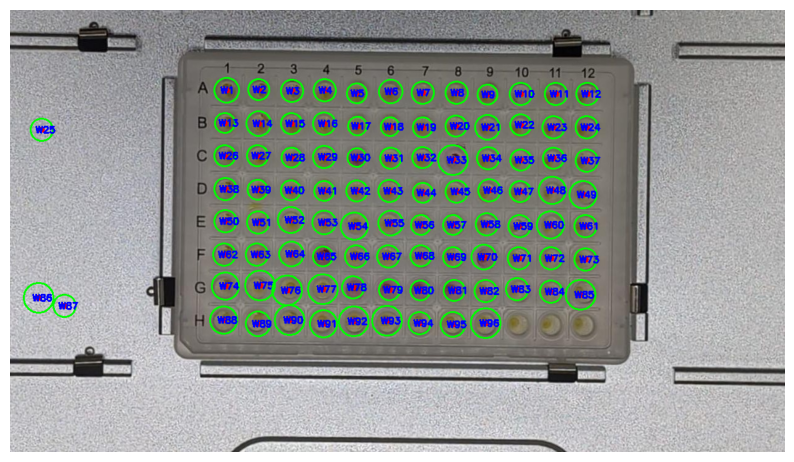

In [2]:

import cv2 as cv  
import numpy as np  
import matplotlib.pyplot as plt  

class Image_processing:
    def __init__(self, image_path, expected_grid=(8, 12)):
        """
        Initialises the Image_processing class with the image path and expected grid dimensions.
        
        Args:
            image_path (str): Path to the image file.
            expected_grid (tuple): Expected grid dimensions (rows, columns) for the well plate.
        """
        self.image_path = image_path  # Store the image path
        self.expected_grid = expected_grid  # Store the expected grid dimensions
        self.image = cv.imread(image_path)  # Load the image using OpenCV
        self.best_circles = None  # Placeholder for detected circles

    def filter_circular_contours(self, contours):
        """
        Filters contours to keep only those that are  circular.
        
        Args:
            contours (list): List of contours detected in the image.
        
        Returns:
            list: List of radii of contours that are  circular.
        """
        # List to store radii of valid circular contours
        valid_circle = []  
        for cont in contours:
            # Calculate the perimeter of the contour
            perimeter = cv.arcLength(cont, True)  

            # Calculate the area of the contour
            area = cv.contourArea(cont)  
            # Avoid division by zero
            if perimeter == 0:
                continue  
            circularity = 4 * np.pi * (area / (perimeter ** 2))  
            if 0.8 < circularity < 1.2:  
                _, radius = cv.minEnclosingCircle(cont)  
                valid_circle.append(radius)  
        return valid_circle
    
    def enforce_grid_pattern(self, circles):
        """
        Enforces a grid pattern on the detected circles to align them with the expected well plate layout.
        
        Args:
            circles (np.ndarray): Detected circles.
        
        Returns:
            np.ndarray: Array of circles aligned in a grid pattern.
        """
        if circles is None or len(circles[0]) < 2:
            return None  
        
        # Extract (x, y, radius) positions of the circles
        circle_positions = circles[0, :, :3]  # Include radius
        
        # Sort circles by Y-coordinate (row-wise sorting)
        sorted_by_y = sorted(circle_positions, key=lambda p: p[1])
        
        # Group circles into rows based on proximity in Y-coordinate
        rows = []
        row_threshold = np.mean(np.diff(sorted_by_y, axis=0)[:, 1]) / 2  # estimate row spacing
        current_row = [sorted_by_y[0]]

        for i in range(1, len(sorted_by_y)):
            if abs(sorted_by_y[i][1] - current_row[-1][1]) < row_threshold:
                current_row.append(sorted_by_y[i])  # Add to current row if Y-coordinate is close
            else:
                rows.append(sorted(current_row, key=lambda p: p[0]))  # Sort row by X-coordinate
                current_row = [sorted_by_y[i]]  # Start a new row

        rows.append(sorted(current_row, key=lambda p: p[0]))  # Add the last row

        # Flatten rows back into a single array
        sorted_circles = np.array([circle for row in rows for circle in row])

        # Limit to expected number of wells (8x12 = 96)
        if len(sorted_circles) > self.expected_grid[0] * self.expected_grid[1]:
            sorted_circles = sorted_circles[:self.expected_grid[0] * self.expected_grid[1]]

        return np.array([sorted_circles], dtype=np.uint16)

    def extract_rgb_values(self, circles, radius=1):
        """
        Extracts the average RGB values at the centers of detected circles.
        
        Args:
            circles (np.ndarray): Detected circles.
            radius (int): Radius for averaging RGB values.
        
        Returns:
            np.ndarray: Array of mean RGB values for each circle.
        """
        # Convert the image from OpenCV's default BGR format to RGB 
        image_rgb = cv.cvtColor(self.image, cv.COLOR_BGR2RGB)
        
        # List to store the mean RGB values for each detected circle
        rgb_values = []
        
        # Iterate through all detected circles to extract RGB values
        for circle in circles[0, :]:
            x, y = circle[0], circle[1]
            rgb = np.zeros(3, dtype=np.float32)
            count = 0
            
            # Iterate over the surrounding pixels within the specified radius to compute mean RGB
            for i in range(-radius, radius + 1):
                for j in range(-radius, radius + 1):
                    # Ensure pixel coordinates are within valid bounds of the image
                    if 0 <= y + i < image_rgb.shape[0] and 0 <= x + j < image_rgb.shape[1]:
                        rgb += image_rgb[y + i, x + j]
                        count += 1
            
            # Compute mean RGB value
            rgb /= count  
            rgb_values.append(rgb.astype(int))
        
        return np.array(rgb_values)

    def auto_hough_circle_detection(self):
        """
        Detects circles in an image and extracts RGB values.
        
        Returns:
            np.ndarray: Array of RGB values for each detected circle, or None if detection fails.
        """
        # Convert the image to grayscale
        gray = cv.cvtColor(self.image, cv.COLOR_BGR2GRAY)
        
        # Apply Contrast Limited Adaptive Histogram Equalization (CLAHE) to enhance contrast
        clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        gray = clahe.apply(gray)
        
        # Apply median blur to reduce noise
        blurred = cv.medianBlur(gray, 5)
        
        # Detect edges using the Canny edge detector
        edges = cv.Canny(blurred, 50, 150)

        # Find contours in the edge-detected image
        contours, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

        if not contours:
            print("No contours found. Check image quality.")
            return None

        # Filter circular contours only
        valid_circle = self.filter_circular_contours(contours)

        if len(valid_circle) < 5:
            print("Not enough valid circles detected from contours.")
            return None

        # Controls threshold for detecting circles and is adjusted to optimise detection.
        param2 = 50
        best_circles = None
        
        # Loop progressively lowers param2 to increase sensitivity
        while param2 >= 10:
            # Circle detection using Hough Circles
            circles = cv.HoughCircles(
                blurred, 
                cv.HOUGH_GRADIENT, 
                dp=1.2, 
                minDist=15,  
                param1=50, 
                param2=param2,  
                minRadius=15, 
                maxRadius=25
            )

            # Compare circles with well plate
            if circles is not None and circles.shape[1] >= self.expected_grid[0] * self.expected_grid[1]:
                best_circles = circles
                break  
            param2 -= 5  
        
        # If circles are detected, enforce grid pattern to remove outliers
        if best_circles is not None:
            best_circles = self.enforce_grid_pattern(best_circles)
            if best_circles is not None:
                rgb_values = self.extract_rgb_values(best_circles)
                self.best_circles = best_circles
                
                # Return the array of RGB values
                return rgb_values
    
        print("Circle detection failed.")
        return None

    def plot_picture(self):
        """
        Plots the image with detected circles and labels.
        
        Returns:
            None: Displays the image using matplotlib.
        """
        if self.best_circles is not None:
            image = self.image.copy()
            for idx, circle in enumerate(self.best_circles[0, :]):
                center = (circle[0], circle[1])
                radius = circle[2]
                cv.circle(image, center, radius, (0, 255, 0), 2)  # Draw green circle
                cv.circle(image, center, 5, (0, 0, 255), -1)  # Draw red bullseye
                cv.putText(image, f"W{idx + 1}", (center[0] - 10, center[1] + 5), 
                            cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)  # Label the circle
            
            # Display result
            plt.figure(figsize=(10, 10))
            plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()

# Example usage
processor = Image_processing('demo2.jpg', expected_grid=(8, 12))
rgb_values = processor.auto_hough_circle_detection()
if rgb_values is not None:
    print("RGB Values:")
    print(rgb_values)
processor.plot_picture()

RGB Values:
[[121  83   3]
 [116  79   2]
 [124  86   4]
 [129  88   2]
 [125  86   1]
 [151 110  31]
 [120  81   2]
 [122  85   0]
 [125  87   3]
 [135  98  11]
 [128  88   0]
 [129  93  15]
 [130  90   5]
 [128  87   2]
 [130  87   6]
 [134  92   2]
 [130  90   0]
 [128  88   3]
 [127  87   2]
 [129  92   3]
 [127  91   2]
 [150 112  23]
 [130  90   3]
 [129  90   0]
 [133  92   1]
 [140  99   7]
 [132  91   0]
 [141  99   2]
 [ 63  23  25]
 [136  94   0]
 [135  96   7]
 [ 51  18  18]
 [129  88   1]
 [146 110  13]
 [131  91   1]
 [130  93   2]
 [148 108  21]
 [137  97   1]
 [145 102   7]
 [135  95   1]
 [141  98   3]
 [138  98   3]
 [135  96   2]
 [138  98   3]
 [136  90   5]
 [135  95   2]
 [133  92   1]
 [127  91   0]
 [135  98   1]
 [146 101   8]
 [147 101  12]
 [149 106   3]
 [137  98   5]
 [141 101   3]
 [136  95   0]
 [136  96   0]
 [137  93   4]
 [145 106  10]
 [132  93   0]
 [131  91   0]
 [144 102   0]
 [150 105   3]
 [144 102   2]
 [ 40   4   8]
 [160 113  25]
 [138  98   2

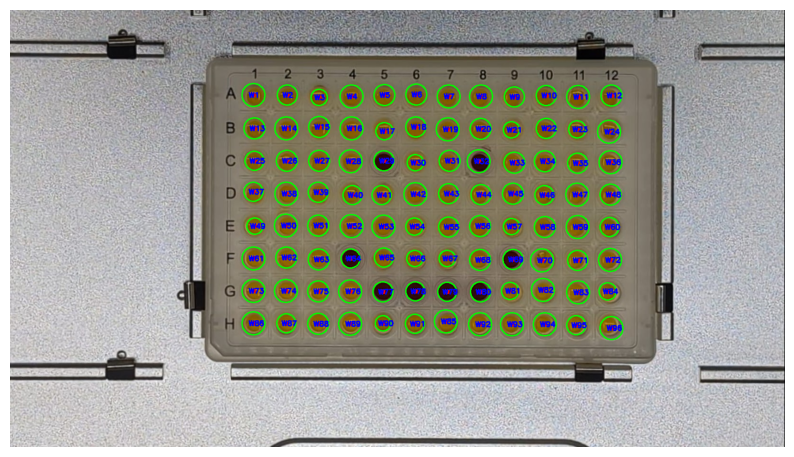

In [3]:

import cv2 as cv  
import numpy as np  
import matplotlib.pyplot as plt  

class Image_processing:
    def __init__(self, image_path, expected_grid=(8, 12)):
        """
        Initialises the Image_processing class with the image path and expected grid dimensions.
        
        Args:
            image_path (str): Path to the image file.
            expected_grid (tuple): Expected grid dimensions (rows, columns) for the well plate.
        """
        self.image_path = image_path  # Store the image path
        self.expected_grid = expected_grid  # Store the expected grid dimensions
        self.image = cv.imread(image_path)  # Load the image using OpenCV
        self.best_circles = None  # Placeholder for detected circles

    def filter_circular_contours(self, contours):
        """
        Filters contours to keep only those that are  circular.
        
        Args:
            contours (list): List of contours detected in the image.
        
        Returns:
            list: List of radii of contours that are  circular.
        """
        # List to store radii of valid circular contours
        valid_circle = []  
        for cont in contours:
            # Calculate the perimeter of the contour
            perimeter = cv.arcLength(cont, True)  

            # Calculate the area of the contour
            area = cv.contourArea(cont)  
            # Avoid division by zero
            if perimeter == 0:
                continue  
            circularity = 4 * np.pi * (area / (perimeter ** 2))  
            if 0.8 < circularity < 1.2:  
                _, radius = cv.minEnclosingCircle(cont)  
                valid_circle.append(radius)  
        return valid_circle
    
    def enforce_grid_pattern(self, circles):
        """
        Enforces a grid pattern on the detected circles to align them with the expected well plate layout.
        
        Args:
            circles (np.ndarray): Detected circles.
        
        Returns:
            np.ndarray: Array of circles aligned in a grid pattern.
        """
        if circles is None or len(circles[0]) < 2:
            return None  
        
        # Extract (x, y, radius) positions of the circles
        circle_positions = circles[0, :, :3]  # Include radius
        
        # Sort circles by Y-coordinate (row-wise sorting)
        sorted_by_y = sorted(circle_positions, key=lambda p: p[1])
        
        # Group circles into rows based on proximity in Y-coordinate
        rows = []
        row_threshold = np.mean(np.diff(sorted_by_y, axis=0)[:, 1]) / 2  # estimate row spacing
        current_row = [sorted_by_y[0]]

        for i in range(1, len(sorted_by_y)):
            if abs(sorted_by_y[i][1] - current_row[-1][1]) < row_threshold:
                current_row.append(sorted_by_y[i])  # Add to current row if Y-coordinate is close
            else:
                rows.append(sorted(current_row, key=lambda p: p[0]))  # Sort row by X-coordinate
                current_row = [sorted_by_y[i]]  # Start a new row

        rows.append(sorted(current_row, key=lambda p: p[0]))  # Add the last row

        # Flatten rows back into a single array
        sorted_circles = np.array([circle for row in rows for circle in row])

        # Limit to expected number of wells (8x12 = 96)
        if len(sorted_circles) > self.expected_grid[0] * self.expected_grid[1]:
            sorted_circles = sorted_circles[:self.expected_grid[0] * self.expected_grid[1]]

        return np.array([sorted_circles], dtype=np.uint16)

    def extract_rgb_values(self, circles, radius=1):
        """
        Extracts the average RGB values at the centers of detected circles.
        
        Args:
            circles (np.ndarray): Detected circles.
            radius (int): Radius for averaging RGB values.
        
        Returns:
            np.ndarray: Array of mean RGB values for each circle.
        """
        # Convert the image from OpenCV's default BGR format to RGB 
        image_rgb = cv.cvtColor(self.image, cv.COLOR_BGR2RGB)
        
        # List to store the mean RGB values for each detected circle
        rgb_values = []
        
        # Iterate through all detected circles to extract RGB values
        for circle in circles[0, :]:
            x, y = circle[0], circle[1]
            rgb = np.zeros(3, dtype=np.float32)
            count = 0
            
            # Iterate over the surrounding pixels within the specified radius to compute mean RGB
            for i in range(-radius, radius + 1):
                for j in range(-radius, radius + 1):
                    # Ensure pixel coordinates are within valid bounds of the image
                    if 0 <= y + i < image_rgb.shape[0] and 0 <= x + j < image_rgb.shape[1]:
                        rgb += image_rgb[y + i, x + j]
                        count += 1
            
            # Compute mean RGB value
            rgb /= count  
            rgb_values.append(rgb.astype(int))
        
        return np.array(rgb_values)

    def auto_hough_circle_detection(self):
        """
        Detects circles in an image and extracts RGB values.
        
        Returns:
            np.ndarray: Array of RGB values for each detected circle, or None if detection fails.
        """
        # Convert the image to grayscale
        gray = cv.cvtColor(self.image, cv.COLOR_BGR2GRAY)
        
        # Apply Contrast Limited Adaptive Histogram Equalization (CLAHE) to enhance contrast
        clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        gray = clahe.apply(gray)
        
        # Apply median blur to reduce noise
        blurred = cv.medianBlur(gray, 5)
        
        # Detect edges using the Canny edge detector
        edges = cv.Canny(blurred, 50, 150)

        # Find contours in the edge-detected image
        contours, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

        if not contours:
            print("No contours found. Check image quality.")
            return None

        # Filter circular contours only
        valid_circle = self.filter_circular_contours(contours)

        if len(valid_circle) < 5:
            print("Not enough valid circles detected from contours.")
            return None

        # Controls threshold for detecting circles and is adjusted to optimise detection.
        param2 = 50
        best_circles = None
        
        # Loop progressively lowers param2 to increase sensitivity
        while param2 >= 10:
            # Circle detection using Hough Circles
            circles = cv.HoughCircles(
                blurred, 
                cv.HOUGH_GRADIENT, 
                dp=1.2, 
                minDist=15,  
                param1=50, 
                param2=param2,  
                minRadius=15, 
                maxRadius=25
            )

            # Compare circles with well plate
            if circles is not None and circles.shape[1] >= self.expected_grid[0] * self.expected_grid[1]:
                best_circles = circles
                break  
            param2 -= 5  
        
        # If circles are detected, enforce grid pattern to remove outliers
        if best_circles is not None:
            best_circles = self.enforce_grid_pattern(best_circles)
            if best_circles is not None:
                rgb_values = self.extract_rgb_values(best_circles)
                self.best_circles = best_circles
                
                # Return the array of RGB values
                return rgb_values
    
        print("Circle detection failed.")
        return None

    def plot_picture(self):
        """
        Plots the image with detected circles and labels.
        
        Returns:
            None: Displays the image using matplotlib.
        """
        if self.best_circles is not None:
            image = self.image.copy()
            for idx, circle in enumerate(self.best_circles[0, :]):
                center = (circle[0], circle[1])
                radius = circle[2]
                cv.circle(image, center, radius, (0, 255, 0), 2)  # Draw green circle
                cv.circle(image, center, 5, (0, 0, 255), -1)  # Draw red bullseye
                cv.putText(image, f"W{idx + 1}", (center[0] - 10, center[1] + 5), 
                            cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)  # Label the circle
            
            # Display result
            plt.figure(figsize=(10, 10))
            plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()

# Example usage
processor = Image_processing('demo3.jpg', expected_grid=(8, 12))
rgb_values = processor.auto_hough_circle_detection()
if rgb_values is not None:
    print("RGB Values:")
    print(rgb_values)
processor.plot_picture()

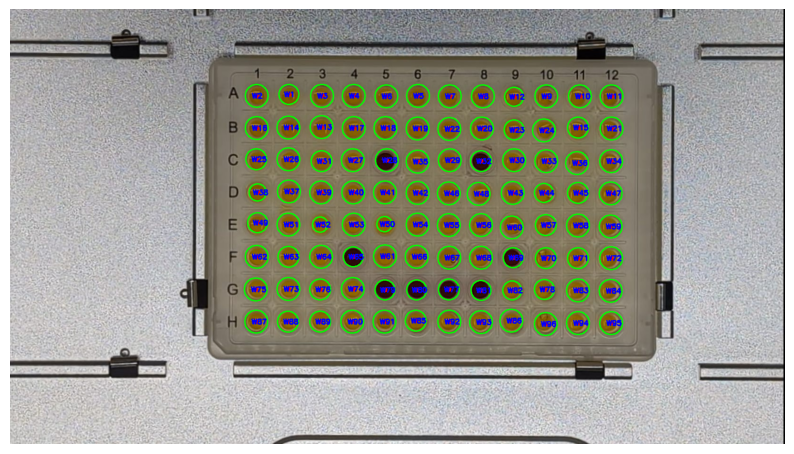

In [14]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

class previous_Image_processing:
    def __init__(self, image_path, expected_grid=(8,12)):
        self.image_path = image_path
        self.expected_grid = expected_grid
        self.image = cv.imread(image_path)
        self.labelled_rgb_values = None  # Store labelled RGB values here
        self.best_circles = None

    def enforce_grid_pattern(self, circles):
        """
        Forces a grid structure on detected circles by sorting and filtering.
        
        Args:
            circles (np.ndarray): Detected circles from HoughCircles.
        
        Returns:
            np.ndarray: Filtered circles arranged in a grid-like pattern.
        """
        if circles is None or len(circles[0]) < 2:
            return None
        
        # Extract (x, y) positions only.
        circle_positions = circles[0, :, :2]
        
        # Sort circles by their y-coordinate (rows) and then by x-coordinate (columns)
        sorted_indices = np.lexsort((circle_positions[:, 0], circle_positions[:, 1]))
        sorted_circles = circles[0, sorted_indices]
        
        # Calculate the expected number of circles
        expected_num_circles = self.expected_grid[0] * self.expected_grid[1]
        
        # If more circles are detected than expected, keep only the first `expected_num_circles`
        if len(sorted_circles) > expected_num_circles:
            sorted_circles = sorted_circles[:expected_num_circles]
        
        return np.array([sorted_circles], dtype=np.uint16)

    def extract_rgb_values(self, circles, radius=1):
        """
        Extracts the average RGB values at the centers of detected circles.
        
        Args:
            circles (np.ndarray): Detected circles.
            radius (int): Radius for averaging RGB values.
        
        Returns:
            np.ndarray: Array of mean RGB values for each circle.
        """
        # Convert the image from OpenCV's default BGR format to RGB 
        image_rgb = cv.cvtColor(self.image, cv.COLOR_BGR2RGB)
        
        # List to store the mean RGB values for each detected circle
        rgb_values = []
        
        # Iterate through all detected circles to extract RGB values
        for circle in circles[0, :]:
            x, y = circle[0], circle[1]
            rgb = np.zeros(3, dtype=np.float32)
            count = 0
            
            # Iterate over the surrounding pixels within the specified radius to compute mean RGB
            for i in range(-radius, radius + 1):
                for j in range(-radius, radius + 1):
                    # Ensure pixel coordinates are within valid bounds of the image
                    if 0 <= y + i < image_rgb.shape[0] and 0 <= x + j < image_rgb.shape[1]:
                        rgb += image_rgb[y + i, x + j]
                        count += 1
            
            # Compute mean RGB value
            rgb /= count  
            rgb_values.append(rgb.astype(int))
        
        return np.array(rgb_values)

    def auto_hough_circle_detection(self):
        """
        Detects circles in an image, extracts RGB values, and prints labelled results.
        
        Returns:
            dict: Labelled RGB values for each detected well, or None if detection fails.
        """
        gray = cv.cvtColor(self.image, cv.COLOR_BGR2GRAY)
        gray = cv.equalizeHist(gray)
        blurred = cv.medianBlur(gray, 5)
        edges = cv.Canny(blurred, 50, 150)

        # Find contours
        contours, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

        if not contours:
            print("No contours found. Check image quality.")
            return None
        
        # Controls threshold for detecting circles and is adjusted to optimise detection.
        param2 = 50
        best_circles = None
        
        # Loop progressively lowers param2 to increase sensitivity
        while param2 >= 10:
            # Circle detection using hough circles
            circles = cv.HoughCircles(
                blurred, 
                cv.HOUGH_GRADIENT, 
                dp=1.2, 
                minDist=15,  
                param1=50, 
                param2=param2,  
                minRadius=15, 
                maxRadius=25
            )

            # Compare circles with well plate
            if circles is not None and circles.shape[1] >= self.expected_grid[0] * self.expected_grid[1]:
                best_circles = circles
                break  
            param2 -= 5  
        
        # If it works, use enforce grid to remove outliers --> align to 96 well plate
        if best_circles is not None:
            best_circles = self.enforce_grid_pattern(best_circles)
            if best_circles is not None:
                rgb_values = self.extract_rgb_values(best_circles)
                circle_positions = best_circles[0, :, :2]
                
                # Sort wells by their positions (top-left to bottom-right order)
                sorted_indices = np.lexsort((circle_positions[:, 0], circle_positions[:, 1]))
                sorted_circles = best_circles[0, sorted_indices]
                
                # Assign well labels
                well_labels = [f"W{i + 1}" for i in range(self.expected_grid[0] * self.expected_grid[1])]
                self.labelled_rgb_values = dict(zip(well_labels, rgb_values[sorted_indices]))
                self.best_circles = sorted_circles

                for well, rgb in self.labelled_rgb_values.items():
                
                    return rgb_values[sorted_indices]

    
        print("Circle detection failed.")
        return None

    def plot_picture(self):
        """
        Plots the image with detected circles and labels.

        Returns:
            None: Displays the image using matplotlib.
        """
        if self.best_circles is not None:
            image = self.image.copy()
            for idx, circle in enumerate(self.best_circles):
                center = (circle[0], circle[1])
                radius = circle[2]
                cv.circle(image, center, radius, (0, 255, 0), 2)
                cv.circle(image, center, 5, (0, 0, 255), -1)  # Red bullseye
                cv.putText(image, f"W{idx + 1}", (center[0] - 10, center[1] + 5), 
                            cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
            
            # Display result
            plt.figure(figsize=(10, 10))
            plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()
processor = previous_Image_processing('demo.jpg', expected_grid=(8, 12))
rgb_values = processor.auto_hough_circle_detection()
processor.plot_picture()

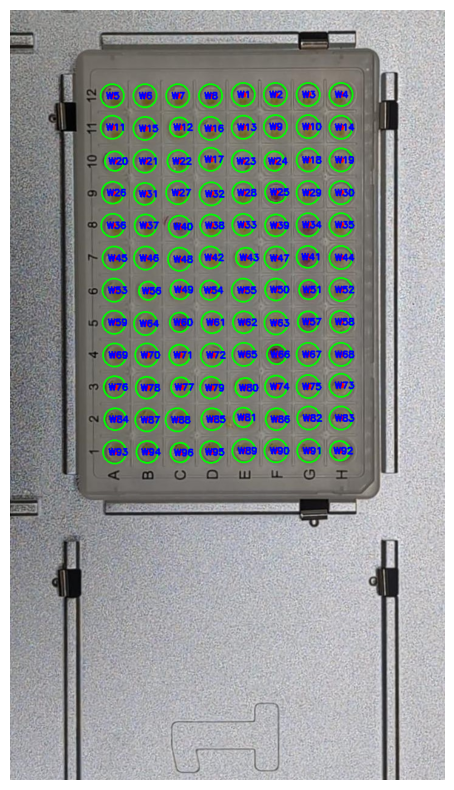

array([[132, 124,  98],
       [131, 123,  92],
       [139, 129, 104],
       [134, 126,  95],
       [118, 108,  88],
       [121, 112,  81],
       [123, 117,  85],
       [123, 118,  89],
       [139, 129, 102],
       [138, 127, 100],
       [116, 110,  86],
       [125, 119,  89],
       [131, 123,  92],
       [132, 124,  92],
       [123, 116,  84],
       [128, 120,  92],
       [129, 123,  93],
       [135, 126,  89],
       [134, 122,  90],
       [113, 111,  99],
       [122, 115,  80],
       [123, 118,  80],
       [123, 122, 105],
       [125, 115,  73],
       [112,  76,  75],
       [117, 110,  81],
       [126, 118,  81],
       [127, 119,  74],
       [124, 118,  77],
       [117, 102,  47],
       [117, 111,  80],
       [120, 111,  66],
       [120, 112,  69],
       [102,  68,  67],
       [121, 111,  67],
       [115, 108,  76],
       [116, 111,  75],
       [122, 113,  67],
       [116, 107,  61],
       [116,  86,  86],
       [100,  61,  60],
       [119, 109

In [11]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

class previous_Image_processing:
    def __init__(self, image_path, expected_grid=(8,12)):
        self.image_path = image_path
        self.expected_grid = expected_grid
        self.image = cv.imread(image_path)
        self.labelled_rgb_values = None  # Store labelled RGB values here
        self.best_circles = None

    def enforce_grid_pattern(self, circles):
        """
        Forces a grid structure on detected circles by sorting and filtering.
        
        Args:
            circles (np.ndarray): Detected circles from HoughCircles.
        
        Returns:
            np.ndarray: Filtered circles arranged in a grid-like pattern.
        """
        if circles is None or len(circles[0]) < 2:
            return None
        
        # Extract (x, y) positions only.
        circle_positions = circles[0, :, :2]
        
        # Sort circles by their y-coordinate (rows) and then by x-coordinate (columns)
        sorted_indices = np.lexsort((circle_positions[:, 0], circle_positions[:, 1]))
        sorted_circles = circles[0, sorted_indices]
        
        # Calculate the expected number of circles
        expected_num_circles = self.expected_grid[0] * self.expected_grid[1]
        
        # If more circles are detected than expected, keep only the first `expected_num_circles`
        if len(sorted_circles) > expected_num_circles:
            sorted_circles = sorted_circles[:expected_num_circles]
        
        return np.array([sorted_circles], dtype=np.uint16)

    def extract_rgb_values(self, circles, radius=1):
        """
        Extracts the average RGB values at the centers of detected circles.
        
        Args:
            circles (np.ndarray): Detected circles.
            radius (int): Radius for averaging RGB values.
        
        Returns:
            np.ndarray: Array of mean RGB values for each circle.
        """
        # Convert the image from OpenCV's default BGR format to RGB 
        image_rgb = cv.cvtColor(self.image, cv.COLOR_BGR2RGB)
        
        # List to store the mean RGB values for each detected circle
        rgb_values = []
        
        # Iterate through all detected circles to extract RGB values
        for circle in circles[0, :]:
            x, y = circle[0], circle[1]
            rgb = np.zeros(3, dtype=np.float32)
            count = 0
            
            # Iterate over the surrounding pixels within the specified radius to compute mean RGB
            for i in range(-radius, radius + 1):
                for j in range(-radius, radius + 1):
                    # Ensure pixel coordinates are within valid bounds of the image
                    if 0 <= y + i < image_rgb.shape[0] and 0 <= x + j < image_rgb.shape[1]:
                        rgb += image_rgb[y + i, x + j]
                        count += 1
            
            # Compute mean RGB value
            rgb /= count  
            rgb_values.append(rgb.astype(int))
        
        return np.array(rgb_values)

    def auto_hough_circle_detection(self):
        """
        Detects circles in an image, extracts RGB values, and prints labelled results.
        
        Returns:
            dict: Labelled RGB values for each detected well, or None if detection fails.
        """
        gray = cv.cvtColor(self.image, cv.COLOR_BGR2GRAY)
        gray = cv.equalizeHist(gray)
        blurred = cv.medianBlur(gray, 5)
        edges = cv.Canny(blurred, 50, 150)

        # Find contours
        contours, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

        if not contours:
            print("No contours found. Check image quality.")
            return None
        
        # Controls threshold for detecting circles and is adjusted to optimise detection.
        param2 = 50
        best_circles = None
        
        # Loop progressively lowers param2 to increase sensitivity
        while param2 >= 10:
            # Circle detection using hough circles
            circles = cv.HoughCircles(
                blurred, 
                cv.HOUGH_GRADIENT, 
                dp=1.2, 
                minDist=15,  
                param1=50, 
                param2=param2,  
                minRadius=15, 
                maxRadius=20
            )

            # Compare circles with well plate
            if circles is not None and circles.shape[1] >= self.expected_grid[0] * self.expected_grid[1]:
                best_circles = circles
                break  
            param2 -= 5  
        
        # If it works, use enforce grid to remove outliers --> align to 96 well plate
        if best_circles is not None:
            best_circles = self.enforce_grid_pattern(best_circles)
            if best_circles is not None:
                rgb_values = self.extract_rgb_values(best_circles)
                circle_positions = best_circles[0, :, :2]
                
                # Sort wells by their positions (top-left to bottom-right order)
                sorted_indices = np.lexsort((circle_positions[:, 0], circle_positions[:, 1]))
                sorted_circles = best_circles[0, sorted_indices]
                
                # Assign well labels
                well_labels = [f"W{i + 1}" for i in range(self.expected_grid[0] * self.expected_grid[1])]
                self.labelled_rgb_values = dict(zip(well_labels, rgb_values[sorted_indices]))
                self.best_circles = sorted_circles

                for well, rgb in self.labelled_rgb_values.items():
                
                    return rgb_values[sorted_indices]

    
        print("Circle detection failed.")
        return None

    def plot_picture(self):
        """
        Plots the image with detected circles and labels.

        Returns:
            None: Displays the image using matplotlib.
        """
        if self.best_circles is not None:
            image = self.image.copy()
            for idx, circle in enumerate(self.best_circles):
                center = (circle[0], circle[1])
                radius = circle[2]
                cv.circle(image, center, radius, (0, 255, 0), 2)
                cv.circle(image, center, 5, (0, 0, 255), -1)  # Red bullseye
                cv.putText(image, f"W{idx + 1}", (center[0] - 10, center[1] + 5), 
                            cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
            
            # Display result
            plt.figure(figsize=(10, 10))
            plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()
processor = previous_Image_processing('demo1.jpg', expected_grid=(8, 12))
rgb_values = processor.auto_hough_circle_detection()
processor.plot_picture()
rgb_values

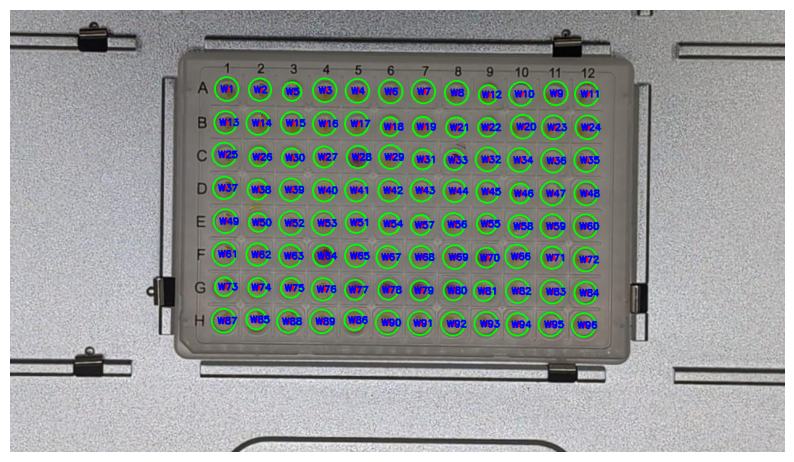

In [13]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

class previous_Image_processing:
    def __init__(self, image_path, expected_grid=(8,12)):
        self.image_path = image_path
        self.expected_grid = expected_grid
        self.image = cv.imread(image_path)
        self.labelled_rgb_values = None  # Store labelled RGB values here
        self.best_circles = None

    def enforce_grid_pattern(self, circles):
        """
        Forces a grid structure on detected circles by sorting and filtering.
        
        Args:
            circles (np.ndarray): Detected circles from HoughCircles.
        
        Returns:
            np.ndarray: Filtered circles arranged in a grid-like pattern.
        """
        if circles is None or len(circles[0]) < 2:
            return None
        
        # Extract (x, y) positions only.
        circle_positions = circles[0, :, :2]
        
        # Sort circles by their y-coordinate (rows) and then by x-coordinate (columns)
        sorted_indices = np.lexsort((circle_positions[:, 0], circle_positions[:, 1]))
        sorted_circles = circles[0, sorted_indices]
        
        # Calculate the expected number of circles
        expected_num_circles = self.expected_grid[0] * self.expected_grid[1]
        
        # If more circles are detected than expected, keep only the first `expected_num_circles`
        if len(sorted_circles) > expected_num_circles:
            sorted_circles = sorted_circles[:expected_num_circles]
        
        return np.array([sorted_circles], dtype=np.uint16)

    def extract_rgb_values(self, circles, radius=1):
        """
        Extracts the average RGB values at the centers of detected circles.
        
        Args:
            circles (np.ndarray): Detected circles.
            radius (int): Radius for averaging RGB values.
        
        Returns:
            np.ndarray: Array of mean RGB values for each circle.
        """
        # Convert the image from OpenCV's default BGR format to RGB 
        image_rgb = cv.cvtColor(self.image, cv.COLOR_BGR2RGB)
        
        # List to store the mean RGB values for each detected circle
        rgb_values = []
        
        # Iterate through all detected circles to extract RGB values
        for circle in circles[0, :]:
            x, y = circle[0], circle[1]
            rgb = np.zeros(3, dtype=np.float32)
            count = 0
            
            # Iterate over the surrounding pixels within the specified radius to compute mean RGB
            for i in range(-radius, radius + 1):
                for j in range(-radius, radius + 1):
                    # Ensure pixel coordinates are within valid bounds of the image
                    if 0 <= y + i < image_rgb.shape[0] and 0 <= x + j < image_rgb.shape[1]:
                        rgb += image_rgb[y + i, x + j]
                        count += 1
            
            # Compute mean RGB value
            rgb /= count  
            rgb_values.append(rgb.astype(int))
        
        return np.array(rgb_values)

    def auto_hough_circle_detection(self):
        """
        Detects circles in an image, extracts RGB values, and prints labelled results.
        
        Returns:
            dict: Labelled RGB values for each detected well, or None if detection fails.
        """
        gray = cv.cvtColor(self.image, cv.COLOR_BGR2GRAY)
        gray = cv.equalizeHist(gray)
        blurred = cv.medianBlur(gray, 5)
        edges = cv.Canny(blurred, 50, 150)

        # Find contours
        contours, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

        if not contours:
            print("No contours found. Check image quality.")
            return None
        
        # Controls threshold for detecting circles and is adjusted to optimise detection.
        param2 = 50
        best_circles = None
        
        # Loop progressively lowers param2 to increase sensitivity
        while param2 >= 10:
            # Circle detection using hough circles
            circles = cv.HoughCircles(
                blurred, 
                cv.HOUGH_GRADIENT, 
                dp=1.2, 
                minDist=15,  
                param1=50, 
                param2=param2,  
                minRadius=15, 
                maxRadius=20
            )

            # Compare circles with well plate
            if circles is not None and circles.shape[1] >= self.expected_grid[0] * self.expected_grid[1]:
                best_circles = circles
                break  
            param2 -= 5  
        
        # If it works, use enforce grid to remove outliers --> align to 96 well plate
        if best_circles is not None:
            best_circles = self.enforce_grid_pattern(best_circles)
            if best_circles is not None:
                rgb_values = self.extract_rgb_values(best_circles)
                circle_positions = best_circles[0, :, :2]
                
                # Sort wells by their positions (top-left to bottom-right order)
                sorted_indices = np.lexsort((circle_positions[:, 0], circle_positions[:, 1]))
                sorted_circles = best_circles[0, sorted_indices]
                
                # Assign well labels
                well_labels = [f"W{i + 1}" for i in range(self.expected_grid[0] * self.expected_grid[1])]
                self.labelled_rgb_values = dict(zip(well_labels, rgb_values[sorted_indices]))
                self.best_circles = sorted_circles

                for well, rgb in self.labelled_rgb_values.items():
                
                    return rgb_values[sorted_indices]

    
        print("Circle detection failed.")
        return None

    def plot_picture(self):
        """
        Plots the image with detected circles and labels.

        Returns:
            None: Displays the image using matplotlib.
        """
        if self.best_circles is not None:
            image = self.image.copy()
            for idx, circle in enumerate(self.best_circles):
                center = (circle[0], circle[1])
                radius = circle[2]
                cv.circle(image, center, radius, (0, 255, 0), 2)
                cv.circle(image, center, 5, (0, 0, 255), -1)  # Red bullseye
                cv.putText(image, f"W{idx + 1}", (center[0] - 10, center[1] + 5), 
                            cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
            
            # Display result
            plt.figure(figsize=(10, 10))
            plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()
processor = previous_Image_processing('demo2.jpg', expected_grid=(8, 12))
rgb_values = processor.auto_hough_circle_detection()
processor.plot_picture()

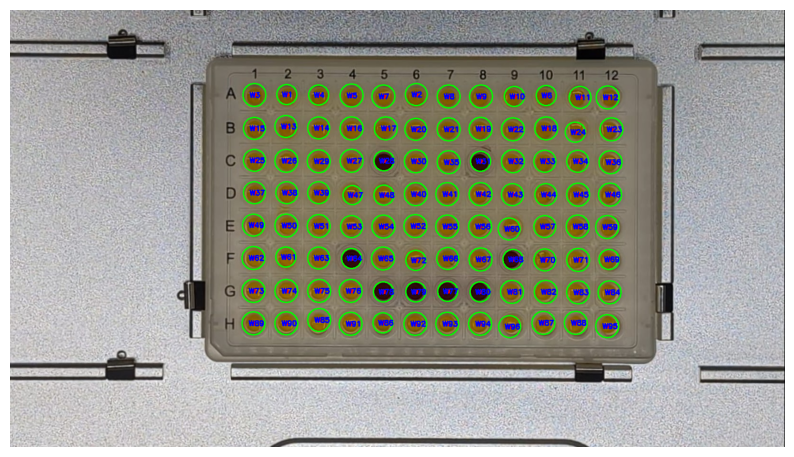

In [7]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

class previous_Image_processing:
    def __init__(self, image_path, expected_grid=(8,12)):
        self.image_path = image_path
        self.expected_grid = expected_grid
        self.image = cv.imread(image_path)
        self.labelled_rgb_values = None  # Store labelled RGB values here
        self.best_circles = None

    def enforce_grid_pattern(self, circles):
        """
        Forces a grid structure on detected circles by sorting and filtering.
        
        Args:
            circles (np.ndarray): Detected circles from HoughCircles.
        
        Returns:
            np.ndarray: Filtered circles arranged in a grid-like pattern.
        """
        if circles is None or len(circles[0]) < 2:
            return None
        
        # Extract (x, y) positions only.
        circle_positions = circles[0, :, :2]
        
        # Sort circles by their y-coordinate (rows) and then by x-coordinate (columns)
        sorted_indices = np.lexsort((circle_positions[:, 0], circle_positions[:, 1]))
        sorted_circles = circles[0, sorted_indices]
        
        # Calculate the expected number of circles
        expected_num_circles = self.expected_grid[0] * self.expected_grid[1]
        
        # If more circles are detected than expected, keep only the first `expected_num_circles`
        if len(sorted_circles) > expected_num_circles:
            sorted_circles = sorted_circles[:expected_num_circles]
        
        return np.array([sorted_circles], dtype=np.uint16)

    def extract_rgb_values(self, circles, radius=1):
        """
        Extracts the average RGB values at the centers of detected circles.
        
        Args:
            circles (np.ndarray): Detected circles.
            radius (int): Radius for averaging RGB values.
        
        Returns:
            np.ndarray: Array of mean RGB values for each circle.
        """
        # Convert the image from OpenCV's default BGR format to RGB 
        image_rgb = cv.cvtColor(self.image, cv.COLOR_BGR2RGB)
        
        # List to store the mean RGB values for each detected circle
        rgb_values = []
        
        # Iterate through all detected circles to extract RGB values
        for circle in circles[0, :]:
            x, y = circle[0], circle[1]
            rgb = np.zeros(3, dtype=np.float32)
            count = 0
            
            # Iterate over the surrounding pixels within the specified radius to compute mean RGB
            for i in range(-radius, radius + 1):
                for j in range(-radius, radius + 1):
                    # Ensure pixel coordinates are within valid bounds of the image
                    if 0 <= y + i < image_rgb.shape[0] and 0 <= x + j < image_rgb.shape[1]:
                        rgb += image_rgb[y + i, x + j]
                        count += 1
            
            # Compute mean RGB value
            rgb /= count  
            rgb_values.append(rgb.astype(int))
        
        return np.array(rgb_values)

    def auto_hough_circle_detection(self):
        """
        Detects circles in an image, extracts RGB values, and prints labelled results.
        
        Returns:
            dict: Labelled RGB values for each detected well, or None if detection fails.
        """
        gray = cv.cvtColor(self.image, cv.COLOR_BGR2GRAY)
        gray = cv.equalizeHist(gray)
        blurred = cv.medianBlur(gray, 5)
        edges = cv.Canny(blurred, 50, 150)

        # Find contours
        contours, _ = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

        if not contours:
            print("No contours found. Check image quality.")
            return None
        
        # Controls threshold for detecting circles and is adjusted to optimise detection.
        param2 = 50
        best_circles = None
        
        # Loop progressively lowers param2 to increase sensitivity
        while param2 >= 10:
            # Circle detection using hough circles
            circles = cv.HoughCircles(
                blurred, 
                cv.HOUGH_GRADIENT, 
                dp=1.2, 
                minDist=15,  
                param1=50, 
                param2=param2,  
                minRadius=20, 
                maxRadius=25
            )

            # Compare circles with well plate
            if circles is not None and circles.shape[1] >= self.expected_grid[0] * self.expected_grid[1]:
                best_circles = circles
                break  
            param2 -= 5  
        
        # If it works, use enforce grid to remove outliers --> align to 96 well plate
        if best_circles is not None:
            best_circles = self.enforce_grid_pattern(best_circles)
            if best_circles is not None:
                rgb_values = self.extract_rgb_values(best_circles)
                circle_positions = best_circles[0, :, :2]
                
                # Sort wells by their positions (top-left to bottom-right order)
                sorted_indices = np.lexsort((circle_positions[:, 0], circle_positions[:, 1]))
                sorted_circles = best_circles[0, sorted_indices]
                
                # Assign well labels
                well_labels = [f"W{i + 1}" for i in range(self.expected_grid[0] * self.expected_grid[1])]
                self.labelled_rgb_values = dict(zip(well_labels, rgb_values[sorted_indices]))
                self.best_circles = sorted_circles

                for well, rgb in self.labelled_rgb_values.items():
                
                    return rgb_values[sorted_indices]

    
        print("Circle detection failed.")
        return None

    def plot_picture(self):
        """
        Plots the image with detected circles and labels.

        Returns:
            None: Displays the image using matplotlib.
        """
        if self.best_circles is not None:
            image = self.image.copy()
            for idx, circle in enumerate(self.best_circles):
                center = (circle[0], circle[1])
                radius = circle[2]
                cv.circle(image, center, radius, (0, 255, 0), 2)
                cv.circle(image, center, 5, (0, 0, 255), -1)  # Red bullseye
                cv.putText(image, f"W{idx + 1}", (center[0] - 10, center[1] + 5), 
                            cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
            
            # Display result
            plt.figure(figsize=(10, 10))
            plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
            plt.axis('off')
            plt.show()
processor = previous_Image_processing('demo3.jpg', expected_grid=(8, 12))
rgb_values = processor.auto_hough_circle_detection()
processor.plot_picture()